# Project Goal

The goal of this project is to predict housing prices from the ['Ames Housing Dataset'](http://www.amstat.org/publications/jse/v19n3/decock.pdf), involving 79 explanatory variables including continuous, categorical and ordinal data types.

The dataset is part of the ['Housing Prices: Advanced Regression Techniques'](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition hosted by Kaggle. Scores are assessed via RMSLE, and scores ranked on the leaderboard.

The RMLSE achieved by this project is 0.12089, placing in the top 23% of scores as of Jan 2019.

This notebook will discuss the results and decision-making for the initial data exploration, missing value imputation, feature engineering, feature selection and regression modelling. 

The models used to fit the data include Ridge Regression, ElasticNet, KernalRidge and Gradient Boosting.

&nbsp;
# Initial Data Exploration

Import the modules we will be using for this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge

Load the train and test data

In [2]:
pd.options.mode.chained_assignment = None # remove dataframe copy warning messages

data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Initial data exploration reveals there are 36 numeric type features, and 43 non-numeric features.
The total number of rows is 1460, however the counts for many columns is less than 1460, indicating missing values.
Some features such as 'PoolQC' and 'MiscFeature' have a majority of missing values.

'SalePrice' is the target variable we are trying to predict.

In [3]:
pd.set_option('display.max_columns', None)
print(data.describe(include='all'))
print('Total data dimensions', data.shape)
print('Data dimensions of numeric features', data.select_dtypes(include=[np.number]).shape)

                 Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1201.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    24.284752    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    59.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    69.000000    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    80.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       Alley LotShape LandContour Utili

The 'Id' column is a unique identifier for each row of data, and does not have any predictive power. We can safely remove these columns.

In [4]:
test_id = test['Id'] # Save to create .csv submission file
data = data.drop(columns=['Id'])
test = test.drop(columns=['Id'])

We can check for features with only one unique value, indicating the feature will have no predictive power. As there is no output, all features have more than one unique value.

In [5]:
for column in data:
    if len(data[column].unique()) <= 1:
        print(column)

# Feature Correlation

Pearson correlations between numerical variables can be visualized using a heatmap. Zero represents no correlation. +1.0 indicates perfect positive correlation, 0 represents no correlation, and -1.0 indicates perfect negative correlation.

The heatmap reveals the most correlated numerical features with 'SalePrice' are 'OverallQual' - The overall quality of the property on an ordinal 1-10 scale, and 'GrLivArea' the area of the living spaces above ground.


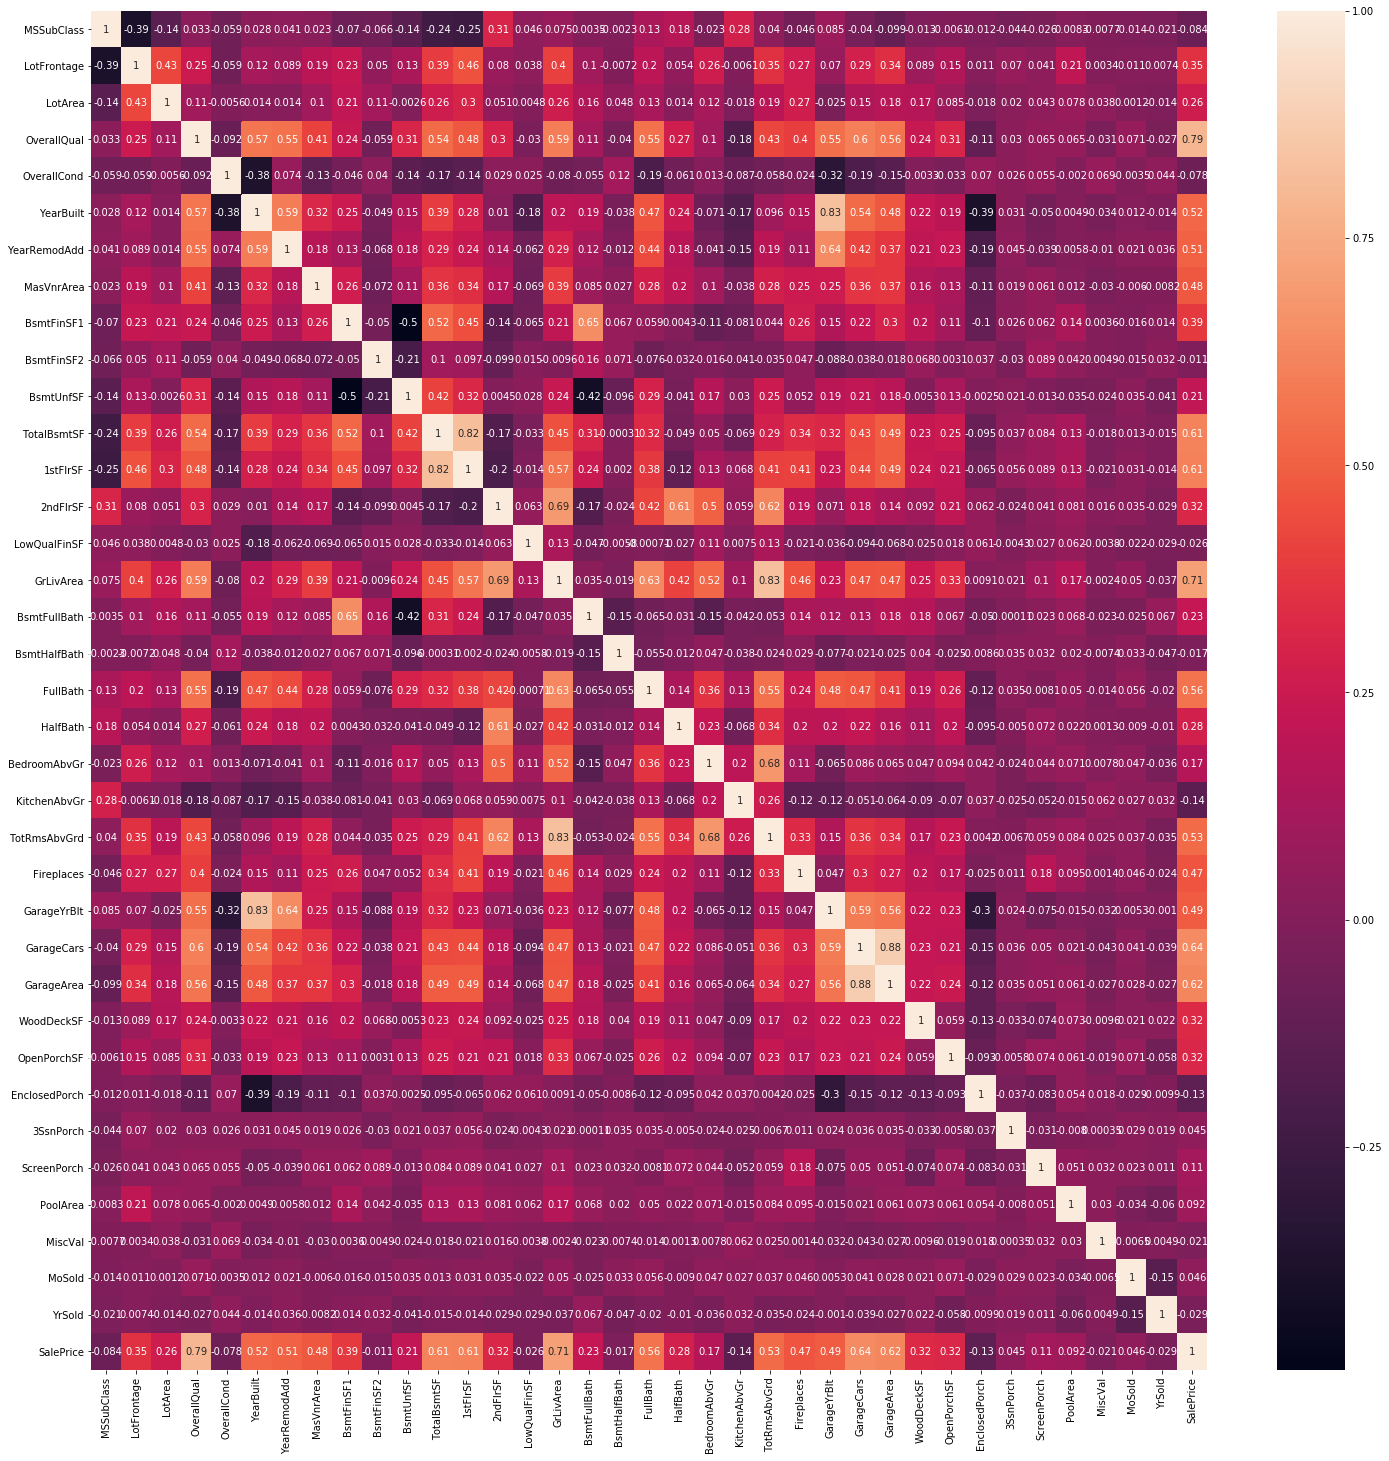

In [6]:
numeric_data = data.select_dtypes(include=[np.number])
correlations = numeric_data.corr()

%matplotlib inline
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(correlations, annot=True)
plt.show()

When looking at correlations between variables we see that several have corelation values > 0.8. Namely, ('GarageCars' and 'GarageArea'), ('GarageYrBlt' and 'YearBuilt'), and ('GrLivArea' and 'TotRmsAbvGrd'). The presence of collinearity can inflate the variance and cause instability in coefficient estimates, so we will remove one variable from each pair of collinear variables. 

Intuitively, the variables represent the same information, for example, the number of cars and the area of the garage are both giving the same information - the size of the garage. Therefore it is probably safe to remove one of these variables for now.

In [7]:
data = data.drop(columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd'])
test = test.drop(columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd'])

# Outliers

By investigating the relationship of each feature with 'SalePrice' we can gain an idea of the distribution of the data, and the presence of any outliers. 

There appear to be several points, for example in the 'LotFrontage', and 'LotArea' feature plots, that lie very far from the main group of datapoints. We will plot these features in more detail in the next cell and explore these points further.

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


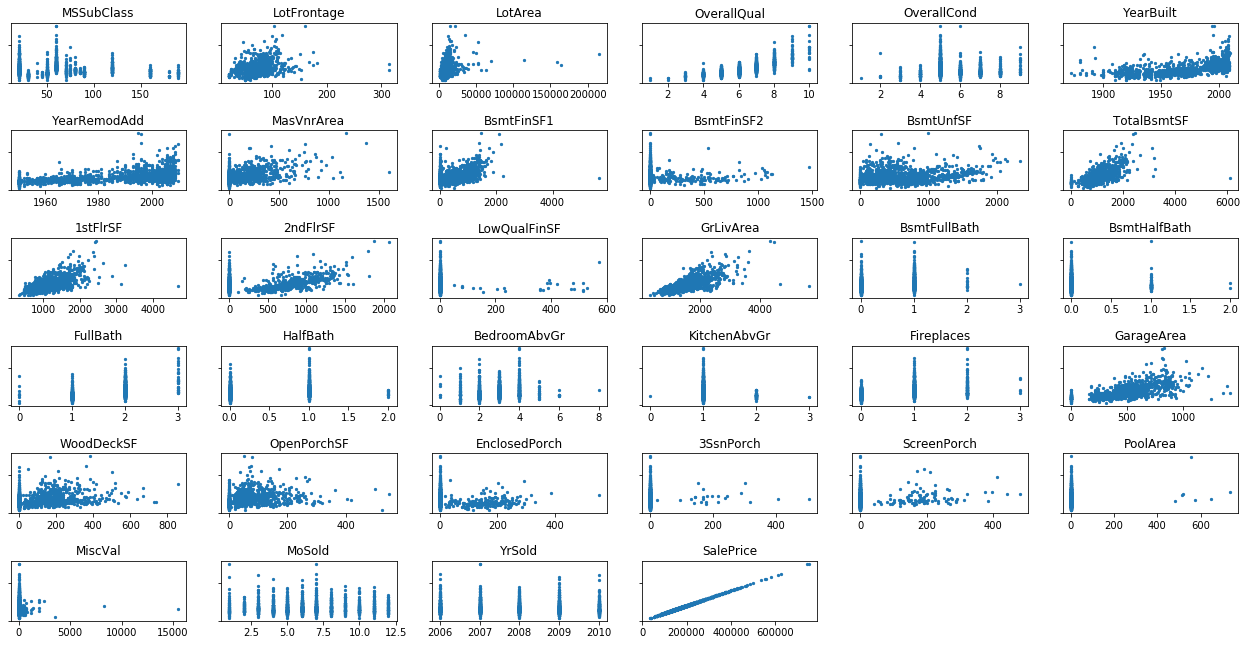

In [8]:
numeric_data = data.select_dtypes(include=[np.number])
print(numeric_data.columns)

%matplotlib inline
f, ax = plt.subplots(6, 6, figsize=(22,11))
for row in range(6):
    for col in range(6):
        idx = col+(6*row)
        if idx < 34:
            x = numeric_data.iloc[:, idx]
            y = numeric_data['SalePrice']
            ax[row, col].scatter(x, y, s=5)
            ax[row, col].set_title(numeric_data.columns[idx])
            ax[row, col].set_yticklabels([])
f.delaxes(ax[5, 4])
f.delaxes(ax[5, 5])
plt.subplots_adjust(hspace=0.8)
plt.show()

To identify possible outliers we can calculate the z-score for each feature. In general, a z-score of 3 or more is indicative of an outlier. Using this constraint on any feature yields many dozens of potential outliers. To constrain our outlier search we choose to identify outliers with z-score >= 5. To avoid information overload, we will look at just 6 continuous features that have high correlation with 'SalePrice'

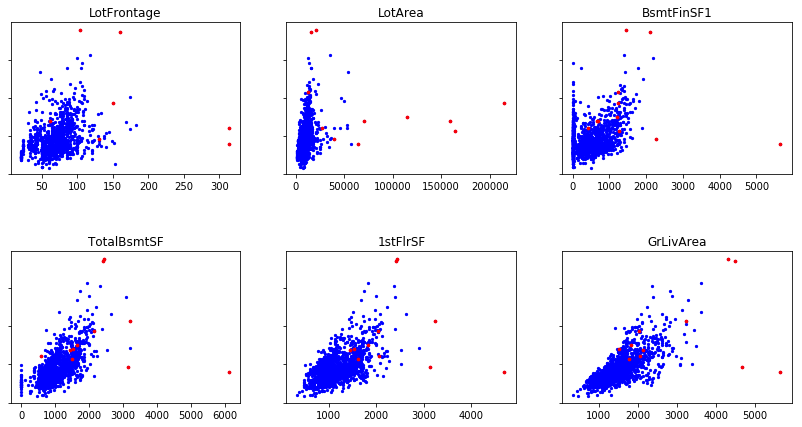

In [9]:
outlier_features = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
outlier_data = data.copy()

zscore_cols = []
# Calculate Z-score for each feature of interest
for col in outlier_features:
    col_zscore = col + '_zscore'
    zscore_cols += [col_zscore]
    outlier_data[col_zscore] = (outlier_data[col] - outlier_data[col].mean())/outlier_data[col].std(ddof=0)

# Get index values of points with z-score >= 5 for any feature
outlier_data = outlier_data[zscore_cols]
outliers = outlier_data[(outlier_data >= 5).any(axis=1)]
outliers_list = outliers.index.tolist()

pd.set_option('display.max_columns', 500)

# Add SalePrice for plotting convenience 
outlier_features += ['SalePrice']
data_only_outliers = data.iloc[outliers_list][outlier_features]
data_outliers = data[outlier_features]

f, ax = plt.subplots(2, 3, figsize=(14,7))
for row in range(3):
    for col in range(3):
        idx = col+(3*row)
        if idx < 6:
            x = data_outliers.iloc[:, idx]
            x_outlier = data_only_outliers.iloc[:, idx]
            y = data_outliers['SalePrice']
            y_outlier = data_only_outliers['SalePrice']
            ax[row, col].scatter(x, y, s=5, c='b')
            ax[row, col].scatter(x_outlier, y_outlier, s=7, c='r')
            ax[row, col].set_title(data_outliers.columns[idx])
            ax[row, col].set_yticklabels([])
plt.subplots_adjust(hspace=0.5)
plt.show()

The scatter plots show that an outlier for one particular feature may not necessarily be an outlier in another. Upon further investigation of the ['Ames Housing Dataset'](http://www.amstat.org/publications/jse/v19n3/decock.pdf) the author of the dataset reveals that there are three true outliers that involve partial sales. He suggests to drop datapoints with 'GrLivArea' > 4000.

After applying the suggested filter, we observe a tighter distribution in the six features, with the number of outliers decreasing from 11 to 8. While the remaining 8 points have a high z-score, without further information there is no reason to believe these are outliers, so we will keep these points in our dataset. Removing these points could lead to over-fitting.

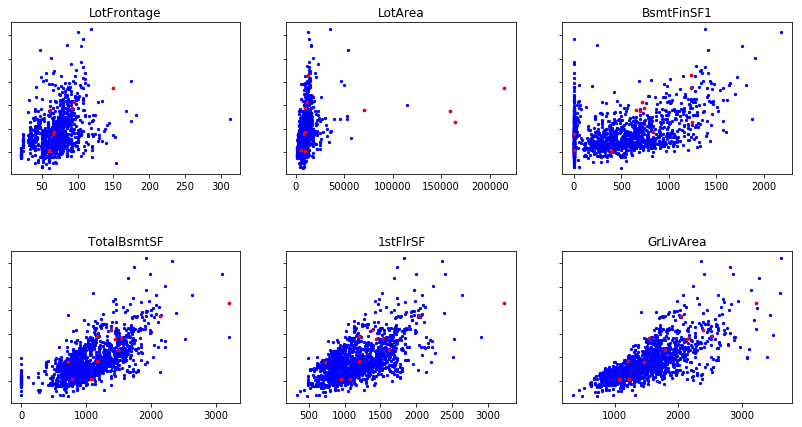

In [10]:
# Apply the filter ['GrLivArea'] < 4000
data = data[data['GrLivArea']<4000]

numeric_data = data.select_dtypes(include=[np.number])

# Re-plot outlier graphs
data_only_outliers = data.iloc[outliers_list][outlier_features]
data_outliers = data[outlier_features]

f, ax = plt.subplots(2, 3, figsize=(14,7))
for row in range(3):
    for col in range(3):
        idx = col+(3*row)
        if idx < 6:
            x = data_outliers.iloc[:, idx]
            x_outlier = data_only_outliers.iloc[:, idx]
            y = data_outliers['SalePrice']
            y_outlier = data_only_outliers['SalePrice']
            ax[row, col].scatter(x, y, s=5, c='b')
            ax[row, col].scatter(x_outlier, y_outlier, s=7, c='r') # outliers will appear red
            ax[row, col].set_title(data_outliers.columns[idx])
            ax[row, col].set_yticklabels([])
plt.subplots_adjust(hspace=0.5)
plt.show()

# Missing Values

Missing values must be imputed in order to retain the maximum information for model training.
Initial exploration of the data reveals missing data in both the train and test sets. Values will be imputed according to data type and number of missing values.

In [11]:
print('Train Set Missing Values')
print()
for col in data:
    num_missing = len(test) - data[col].count()
    if num_missing > 0:
        print(col, num_missing, str(round(num_missing/len(data)*100))+ '%')
print()
print('Test Set Missing Values')
print()
for col in test:
    num_missing = len(test) - test[col].count()
    if num_missing > 0:
        print(col, num_missing, str(round(num_missing/len(test)*100))+ '%')

Train Set Missing Values

MSSubClass 3 0.0%
MSZoning 3 0.0%
LotFrontage 262 18.0%
LotArea 3 0.0%
Street 3 0.0%
Alley 1368 94.0%
LotShape 3 0.0%
LandContour 3 0.0%
Utilities 3 0.0%
LotConfig 3 0.0%
LandSlope 3 0.0%
Neighborhood 3 0.0%
Condition1 3 0.0%
Condition2 3 0.0%
BldgType 3 0.0%
HouseStyle 3 0.0%
OverallQual 3 0.0%
OverallCond 3 0.0%
YearBuilt 3 0.0%
YearRemodAdd 3 0.0%
RoofStyle 3 0.0%
RoofMatl 3 0.0%
Exterior1st 3 0.0%
Exterior2nd 3 0.0%
MasVnrType 11 1.0%
MasVnrArea 11 1.0%
ExterQual 3 0.0%
ExterCond 3 0.0%
Foundation 3 0.0%
BsmtQual 40 3.0%
BsmtCond 40 3.0%
BsmtExposure 41 3.0%
BsmtFinType1 40 3.0%
BsmtFinSF1 3 0.0%
BsmtFinType2 41 3.0%
BsmtFinSF2 3 0.0%
BsmtUnfSF 3 0.0%
TotalBsmtSF 3 0.0%
Heating 3 0.0%
HeatingQC 3 0.0%
CentralAir 3 0.0%
Electrical 4 0.0%
1stFlrSF 3 0.0%
2ndFlrSF 3 0.0%
LowQualFinSF 3 0.0%
GrLivArea 3 0.0%
BsmtFullBath 3 0.0%
BsmtHalfBath 3 0.0%
FullBath 3 0.0%
HalfBath 3 0.0%
BedroomAbvGr 3 0.0%
KitchenAbvGr 3 0.0%
KitchenQual 3 0.0%
Functional 3 0.0%
Firep

Upon inspection of the data, for most categorical features a missing value indicates that the feature is not present, rather than missing data. For example, 'PoolQC'= NA means the house does not have a pool, rather than there is missing data on the pool quality. For these data points we will replace NA with 'NotPresent'.

The remaining missing values in the categorical variables will be imputed with the mode value.

The missing values for continuous garage and basement values correspond to the non-presence of a garage or basement, therefore these values should be imputed as zero.

In [12]:
# NA means feature not prsent. Fill NA with not present
for feature in ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
    data[feature] = data[feature].fillna('NotPresent')
    test[feature] = test[feature].fillna('NotPresent')
    
#For remaining categorical data impute with mode value
for feature in ['MasVnrType', 'Electrical', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']:
    value = data[feature].value_counts().keys()[0] # The key of value_counts() at index[0] is the mode value
    data[feature] = data[feature].fillna(value)
    test[feature] = test[feature].fillna(value)
    
#For MasVnrArea since the missing rows have MasVnrType as None, the Area should be zero
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)


#For BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath if there is no basment, these missing values should be zero
for feature in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    data.loc[data['BsmtFinType1'] == 'NotPresent', feature] = 0
    test.loc[test['BsmtFinType1'] == 'NotPresent', feature] = 0
    
#For GaragaArea if there is no garage the missing value should be zero
data.loc[data['GarageFinish'] == 'NotPresent', 'GarageArea'] = 0
test.loc[test['GarageFinish'] == 'NotPresent', 'GarageArea'] = 0
    

The proportion of missing values in 'LotFrontage' is 18%. This is much higher than for other continuous variables. 'LotFrontage' represents the linear feet of street connected to the property. 

From the correlation heatmap, the most correlated variables to 'LotFrontage' are 'LotArea' and '1stFlrSF'. Therefore we can use these two features and make a simple linear regression model to impute the values of 'LotFrontage' more accurately than using the a single descriptive statistic.

The residual plot shows two outliers, however the majority of points lie within the main cluster. Ignoring the outliers the cluster is fairly random, so this model is probably good enough to impute the missing values.

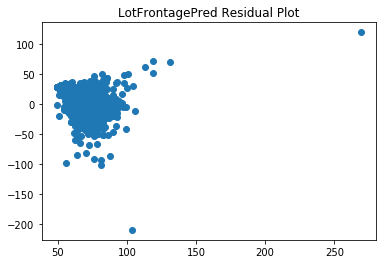

In [13]:
lotdata = data[['LotArea', '1stFlrSF', 'LotFrontage']]
lotdata = lotdata.dropna()

x = lotdata[['LotArea', '1stFlrSF']]
y = lotdata['LotFrontage']

y = y.values.reshape(-1, 1)
all_x = data[['LotArea', '1stFlrSF']]
test_all_x = test[['LotArea', '1stFlrSF']]

linear_lotfrontage = LinearRegression()
linear_lotfrontage.fit(x, y)

linear_pred = linear_lotfrontage.predict(all_x)
test_linear_pred = linear_lotfrontage.predict(test_all_x)

# Create a new column for predicted values
data['LotFrontagePred'] = linear_pred
test['LotFrontagePred'] = test_linear_pred

residuals_linear = data['LotFrontagePred'] - data['LotFrontage']

# Plot residuals
plt.scatter(data['LotFrontagePred'], residuals_linear)
plt.title('LotFrontagePred Residual Plot')
plt.show()

In [14]:
# Used predicted values column to fill the missing data
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontagePred'])
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontagePred'])

# Drop predicted value columns
data = data.drop(columns=['LotFrontagePred'])
test = test.drop(columns=['LotFrontagePred'])

# Feature Engineering

Upon further inspection of the data, several features can be combined into a new feature that may have greater predictive power.

The total bathrooms of the property may be calculated by the addition of 'BsmtFullBath', 'FullBath', 'BsmtHalfBath' and 'HalfBath' features.

Likewise, the total square footage of the property may be calulcated by the addition of 'TotalBsmtSF' and 'GrLivArea'

In [15]:
data['TotalBaths'] = data['BsmtFullBath'] + data['FullBath'] + 0.5*(data['BsmtHalfBath'] + data['HalfBath'])
test['TotalBaths'] = test['BsmtFullBath'] + test['FullBath'] + 0.5*(test['BsmtHalfBath'] + test['HalfBath'])

data['TotalSF'] = data['TotalBsmtSF'] + data['GrLivArea']
test['TotalSF'] = test['TotalBsmtSF'] + test['GrLivArea']

So far, all features are linear and untransformed, however for highly correlated continuous features there may be a benefit to add quadratic terms. Referring back to the 'SalePrice' - Feature scatter plots in the outlier section, visually, the highly correlated variables may have some quadratic shape, therefore for Pearson correlation >0.3 we will add second power terms.

In [16]:
numeric_data = data.select_dtypes(include=[np.number])

# Create a dictionary where the key is the column, and the value is the correlation
numeric_corr_dict = {}
for col in numeric_data.columns:
    numeric_corr_dict[col] = numeric_data[col].corr(data['SalePrice'])
    
# Sort the dictionary and select only values with correlation > 0.3
numeric_corr_dict_sorted = sorted(numeric_corr_dict.items(), key=lambda kv: kv[1], reverse=True)
numeric_quadratics =  [k for k,v in numeric_corr_dict.items() if abs(v) >= 0.3]

numeric_quadratics.remove('SalePrice')

# Create power term features
for col in numeric_quadratics:
    data[col+"**2"] = data[col]**2
    test[col+"**2"] = test[col]**2

Many of the numerical features also seem to exhibit some skew and heteroscedasticity, however linear regression does not require that predictor variables are normally distributed, only that the errors (approximated by the residuals) should be normal. Decision tree based methods are also invariant to transformations in the variables.

The response variable 'SalePrice' also exhibits right skew. While it is not a requirement that the response variable be normally distributed, there may be some benefit to the distribution of the errors. We can apply a log(1+p) transformation to the skewed data.

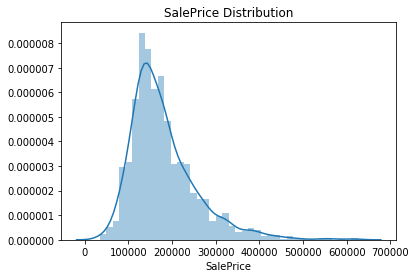

In [17]:
sns.distplot(data['SalePrice'])
plt.title('SalePrice Distribution')
plt.show()

After transforming the data we can see that the distribution of 'SalePrice' is no longer right skewed

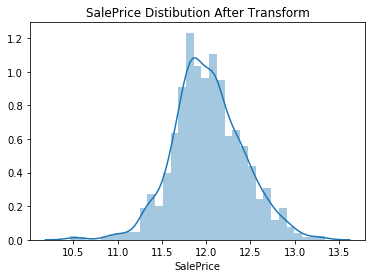

In [18]:
numeric_data = data.select_dtypes(include=[np.number])

# Quantify skew for all variables
skewed_table = abs(numeric_data.skew(axis = 0))

# If skew is > 0.5, then apply the log1p transform
skewed_numeric = skewed_table[skewed_table > 0.5].index
skewed_numeric_test = skewed_numeric.drop('SalePrice')

data[skewed_numeric] = np.log1p(data[skewed_numeric])
test[skewed_numeric_test] = np.log1p(test[skewed_numeric_test])

sns.distplot(data['SalePrice'])
plt.title('SalePrice Distibution After Transform')
plt.show()

The plots of categorical SalePrice - Categorical Feature show there are ordinal variables that have not been numerically coded. For all other categorical variables with no order we will dummy code each level into a separate feature.

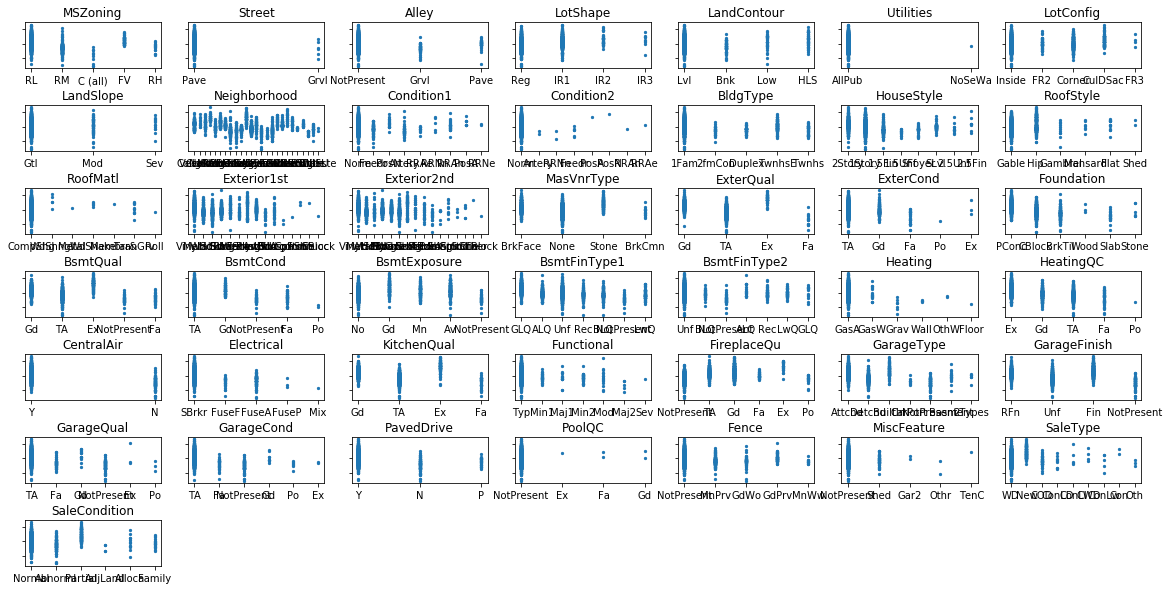

In [19]:
cat_data = data.select_dtypes(include=['object', 'category'])
cat_data['SalePrice'] = data['SalePrice'].copy()

f, ax = plt.subplots(7, 7, figsize=(20,10))
for row in range(7):
    for col in range(7):
        idx = col+(7*row)
        if idx < 44:
            x=cat_data.iloc[:, idx]
            y=cat_data['SalePrice']
            ax[row, col].scatter(x, y, s=5)
            ax[row, col].set_title(cat_data.columns[idx])
            ax[row, col].set_yticklabels([])
for i in range(6):
    f.delaxes(ax[6, i+1])
plt.subplots_adjust(hspace=0.8)
plt.show()

We will keep only the ordinal variables that exhibit some correlation with 'SalePrice', taken to be > 0.3. The features that do not meet the threshold will be dummy coded along with the rest of the remaining categorical features.

In [20]:
# List ordinal features according to their levels, ordinal_1 all share the same levels 
ordinal_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_2 = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence']
ordinal = ordinal_1 + ordinal_2

# Create a function to save repeating code
def ordinal_coding(df):
    ord_data = df[ordinal]
    for col in ordinal_1:
        try:
            ord_data.loc[ord_data[col] == 'Ex', col] = 5
            ord_data.loc[ord_data[col] == 'Gd', col] = 4
            ord_data.loc[ord_data[col] == 'TA', col] = 3
            ord_data.loc[ord_data[col] == 'Fa', col] = 2
            ord_data.loc[ord_data[col] == 'Po', col] = 1
            ord_data.loc[ord_data[col] == 'NotPresent', col] = 0
        except:
            pass

    ord_data.loc[ord_data['BsmtExposure'] == 'Gd','BsmtExposure'] = 4
    ord_data.loc[ord_data['BsmtExposure'] == 'Av','BsmtExposure'] = 3
    ord_data.loc[ord_data['BsmtExposure'] == 'Mn','BsmtExposure'] = 2
    ord_data.loc[ord_data['BsmtExposure'] == 'No','BsmtExposure'] = 1
    ord_data.loc[ord_data['BsmtExposure'] == 'NotPresent','BsmtExposure'] = 0

    ord_data.loc[ord_data['BsmtFinType1'] == 'GLQ','BsmtFinType1'] = 6
    ord_data.loc[ord_data['BsmtFinType1'] == 'ALQ','BsmtFinType1'] = 5
    ord_data.loc[ord_data['BsmtFinType1'] == 'BLQ','BsmtFinType1'] = 4
    ord_data.loc[ord_data['BsmtFinType1'] == 'Rec','BsmtFinType1'] = 3
    ord_data.loc[ord_data['BsmtFinType1'] == 'LwQ','BsmtFinType1'] = 2
    ord_data.loc[ord_data['BsmtFinType1'] == 'Unf','BsmtFinType1'] = 1
    ord_data.loc[ord_data['BsmtFinType1'] == 'NotPresent','BsmtFinType1'] = 0

    ord_data.loc[ord_data['BsmtFinType2'] == 'GLQ','BsmtFinType2'] = 6
    ord_data.loc[ord_data['BsmtFinType2'] == 'ALQ','BsmtFinType2'] = 5
    ord_data.loc[ord_data['BsmtFinType2'] == 'BLQ','BsmtFinType2'] = 4
    ord_data.loc[ord_data['BsmtFinType2'] == 'Rec','BsmtFinType2'] = 3
    ord_data.loc[ord_data['BsmtFinType2'] == 'LwQ','BsmtFinType2'] = 2
    ord_data.loc[ord_data['BsmtFinType2'] == 'Unf','BsmtFinType2'] = 1
    ord_data.loc[ord_data['BsmtFinType2'] == 'NotPresent','BsmtFinType2'] = 0

    ord_data.loc[ord_data['Functional'] == 'Typ','Functional'] = 7
    ord_data.loc[ord_data['Functional'] == 'Min1','Functional'] = 6
    ord_data.loc[ord_data['Functional'] == 'Min2','Functional'] = 5
    ord_data.loc[ord_data['Functional'] == 'Mod','Functional'] = 4
    ord_data.loc[ord_data['Functional'] == 'Maj1','Functional'] = 3
    ord_data.loc[ord_data['Functional'] == 'Maj2','Functional'] = 2
    ord_data.loc[ord_data['Functional'] == 'Sev','Functional'] = 1
    # ord_data.loc[ord_data['Functional'] == 'Sal','Functional'] = 0  # This level is missing from both train and test 

    ord_data.loc[ord_data['GarageFinish'] == 'Fin','GarageFinish'] = 3
    ord_data.loc[ord_data['GarageFinish'] == 'RFn','GarageFinish'] = 2
    ord_data.loc[ord_data['GarageFinish'] == 'Unf','GarageFinish'] = 1
    ord_data.loc[ord_data['GarageFinish'] == 'NotPresent','GarageFinish'] = 0

    ord_data.loc[ord_data['Fence'] == 'GdPrv','Fence'] = 4
    ord_data.loc[ord_data['Fence'] == 'MnPrv','Fence'] = 3
    ord_data.loc[ord_data['Fence'] == 'GdWo','Fence'] = 2
    ord_data.loc[ord_data['Fence'] == 'MnWw','Fence'] = 1
    ord_data.loc[ord_data['Fence'] == 'NotPresent','Fence'] = 0
    return ord_data


ord_data = ordinal_coding(data)
test_ord_data = ordinal_coding(test)

# Obtain the correlation for each ordinal variable, and keep only those with correlation > 0.3
ord_data['SalePrice'] = data['SalePrice'].copy()
ordinal_corr_dict = {}
for col in ordinal:
    ordinal_corr_dict[col] = ord_data[col].corr(ord_data['SalePrice'])
    
ordinal_keep =  [k for k,v in ordinal_corr_dict.items() if abs(v) >= 0.3]

# Implement numeric coding of ordinal features
data[ordinal_keep] = ord_data[ordinal_keep]
test[ordinal_keep] = test_ord_data[ordinal_keep]

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence']


In [21]:
# Identify non-ordinal categorical columns
cat_cols = [col for col in cat_data.columns if col not in ordinal_keep]
cat_cols.remove('SalePrice')

dummy_df = pd.get_dummies(data[cat_cols])
test_dummy_df = pd.get_dummies(test[cat_cols])

data = pd.concat([data, dummy_df], axis=1)
test = pd.concat([test, test_dummy_df], axis=1)

data = data.drop(columns=cat_cols, axis=1)
test = test.drop(columns=cat_cols, axis=1)

# The train and test columns do not have the same levels so we create columns for missing levels to maintain dimensionality
missing_cols = set(data.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0

test = test[data.columns]
test = test.drop(columns=['SalePrice'])

In [ ]:
#Feature selection
#Currently we have 256 features after dummy coding. Too many features will lead to over-fitting
#We can assess feature importance using various methods such as RFE, Gradient Boosting, Chi-Squared, Regularization
#We need a multivariate feature selection method so it can take into account of unknown relationships between features


fs_y = data['SalePrice'].copy()
fs_x = data.copy().drop(columns='SalePrice')

#print(fs_y.shape)
#print(fs_x.shape)

model = XGBRegressor()
model.fit(fs_x, fs_y)
#print(model.feature_importances_)


"""
#plot_importance(model, max_num_features=63)
#plt.show()


#Obtain best threshold value for minimizing RMSE

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(fs_x, fs_y , test_size=0.33, random_state=7)
# fit model on all training data
model = XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
RMSE = (np.sum((y_pred - y_test)**2))**0.5
print("RMSE: %.2f" % (RMSE))
# Fit model using each importance as a threshold
thresholds = np.unique(np.sort(model.feature_importances_))
print(thresholds)

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    RMSE = (np.sum((np.expm1(y_test) - np.expm1(y_pred)) ** 2)/len(X_test)) ** 0.5
    print("Thresh=%.3f, n=%d, RMSE: %.5f" % (thresh, select_X_train.shape[1], RMSE))
"""

#The lowest RMSE is obtained when threshold is = 0.007 the most important features are selected which are:

from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(model, threshold=0.001, prefit=True)
feature_idx = selection.get_support()
feature_x = fs_x.columns[feature_idx]
print(feature_x)




from sklearn.model_selection import GridSearchCV, train_test_split


X = data[feature_x]

print(X.shape)
Y = data['SalePrice']

# A parameter grid for XGBoost
#params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
#'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


params = {
 'max_depth':[4],
 'min_child_weight':[2],
 'gamma': [0],
 'subsample': [0.8],
 'colsample_bytree': [0.8],
 #'reg_alpha':[0.01],
 'scale_pos_weight': [1],
 'random_state': [0],
 'learning_rate': [0.01],
 'n_estimators':[1000]
}

# Initialize XGB and GridSearch


xgb = XGBRegressor()

grid = GridSearchCV(xgb, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)

y_pred_xgb = grid.best_estimator_.predict(X)
y_test = Y
best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_
print(grid.cv_results_)
print(best_params)
print(best_score)
print(best_knn)

X_test = test[feature_x]
test_ensemble_xgb = grid.best_estimator_.predict(X_test)
"""
X_test = test[feature_x]
xgboost_pred = np.expm1(grid.best_estimator_.predict(X_test))
prediction = pd.DataFrame(test_id, columns=['Id'])
prediction['SalePrice'] = xgboost_pred
prediction.to_csv('submission.csv', index=False)
"""

KR = KernelRidge()

params = {'alpha': [0.03],
          'kernel': ['polynomial'],
          'coef0': [50],
          'degree': [1]}

grid = GridSearchCV(KR, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)

y_pred_kr = grid.best_estimator_.predict(X)
y_test = Y
best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_
print(grid.cv_results_)
print(best_params)
print(best_score)
print(best_knn)

X_test = test[feature_x]
test_ensemble_kr = grid.best_estimator_.predict(X_test)

"""
kr_pred = np.expm1(grid.best_estimator_.predict(X_test))
prediction = pd.DataFrame(test_id, columns=['Id'])
prediction['SalePrice'] = kr_pred
prediction.to_csv('submission.csv', index=False)
"""
#LASSO/ELASTIC NET




Y = data['SalePrice']
X = data.drop(columns=['SalePrice'])



EN_model = ElasticNet(normalize=True)
params = {'alpha': [2e-4, 1e-4, 9e-3],
          'l1_ratio': [.93,.95,.97]}

grid = GridSearchCV(EN_model, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_
print(grid.cv_results_)
print(best_params)
print(best_score)
print(list(zip(grid.best_estimator_.coef_, X.columns)))

y_pred_en = grid.best_estimator_.predict(X)

X_test = test
test_ensemble_en = grid.best_estimator_.predict(X_test)


#Create an ensemble model from all XGBoost, Kernel Ridge and Elastic net models
"""
ensemble = pd.DataFrame(data['SalePrice'], columns=['SalePrice'])


ensemble['SalePrice'] = data['SalePrice']
ensemble['XGB'] = y_pred_xgb
ensemble['kr'] = y_pred_kr
ensemble['en'] = y_pred_en

ensemble_Y = ensemble['SalePrice']
ensemble_X = ensemble[['kr', 'en']]

ensemble_EN = ElasticNet(normalize=True)
params = {'alpha': [1e-7],
          'l1_ratio': [0.25, 0.3, 0.35]}

grid = GridSearchCV(ensemble_EN, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(ensemble_X, ensemble_Y)
best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_
print(grid.cv_results_)
print(best_params)
print(best_score)
print(list(zip(grid.best_estimator_.coef_, ['kr', 'en'])))

test_ensemble = pd.DataFrame(test_ensemble_xgb, columns=['XGB'])
test_ensemble['XGB'] = test_ensemble_xgb
test_ensemble['kr'] = test_ensemble_kr
test_ensemble['en'] = test_ensemble_en

test_ensemble_X = test_ensemble[['kr', 'en']]

print(test_ensemble.head())

ensemble_pred = np.expm1(grid.best_estimator_.predict(test_ensemble_X))
prediction = pd.DataFrame(test_id, columns=['Id'])
prediction['SalePrice'] = ensemble_pred
prediction.to_csv('submission.csv', index=False)
"""

EN_pred = np.expm1(grid.best_estimator_.predict(X_test))
prediction = pd.DataFrame(test_id, columns=['Id'])
prediction['SalePrice'] = EN_pred
prediction.to_csv('submission.csv', index=False)

#Try ridge CV



"""
#SVR
Y = data['SalePrice']
X = data.drop(columns=['SalePrice'])

svr_model = SVR()

params = {'C':[1],
              'kernel':['poly','rbf','sigmoid']}
grid = GridSearchCV(svr_model, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_
print(grid.cv_results_)
print(best_params)
print(best_score)

"""
"""
##LOOK AT RESSIDUAL PLOT
residuals_train = y_pred - y_test
print(np.mean(residuals_train))

f, ax = plt.subplots(2, 2, figsize=(50,50))
ax[0, 0].scatter(y_pred, residuals_train)
ax[0, 1].scatter(y_pred, y_test)
plt.show()
#-0.013878054892817572 thresh 0.005 XGB gamma 0, max_depth 4, min_child_weight 2, colsample_bytree 0.8, subsample:0.7
#-0.012595452819610175 EN {'alpha': 0.0001, 'l1_ratio': 0.99}

#with quadratic columns
#-0.0122375 EN {'alpha': 0.0001, 'l1_ratio': 0.99} with quadratic numerical columns threshold 0.3 (no skew corr)
#-0.0125825 EN {'alpha': 0.0001, 'l1_ratio': 0.95 with quadratic numerical columns threshold 0.1

#with qc + new variables:
#-0.013137182554602458 XGBthresh 0.001 XGB gamma 0, max_depth 4, min_child_weight 2, colsample_bytree 0.8, subsample:0.8
#-0.012888155481127268 XGBthresh 0.001 KernelRidge(alpha=0.03, coef0=50, degree=1, gamma=None, kernel='polynomial',
      kernel_params=None)
#-0.012257447435523235 EN {'alpha': 0.0001, 'l1_ratio': 0.99}
